In [1]:
#produce all data figures used for the paper and thesis on MT

In [2]:
using PrettyPlot, JLD2, StatsBase, PyPlot, DSP, LsqFit, HypothesisTests

In [3]:
#functions
function nanmean(x)  
    if sum(isnan.(x))==length(x)
        return NaN
    end
    mean(filter(!isnan,x))
end
nanmean(x,y) = mapslices(nanmean,x,y)
function nanstd(x) 
    if sum(isnan.(x))==length(x)
        return NaN
    end
    std(filter(!isnan,x))
end
nanstd(x,y) = mapslices(nanstd,x,y)
function smooth(y, w_len=11, w_method=2)
    # This function requires the DSP package to be installed
    # 1: flat
    # 2: hanning
    # 3: hamming ...
    if w_len%2==0
        w_len+=1 #make odd for window length
    end
    if w_method == 1
        w=ones(w_len)
    elseif w_method == 2
        w=DSP.hanning(w_len)
    elseif w_method == 3
        w=DSP.hamming(w_len)
    end
    
    if (w_len < 3) || (length(y) < w_len) #not long enough
        return y
    else
        y_new = [2*y[1].-reverse(y[1:w_len],1); y[:]; 2*y[end].-reverse(y[end-w_len:end],1)]
        y_smooth = conv(y_new, w/sum(w))
        ind = floor(Int, 1.5*w_len)
        return y_smooth[1+ind:end-ind-1]
    end
end
function speeddecode(ps, pr, nr, e)
    s = 2^( sum((pr.-nr).*log2.(ps) ) / (e+sum(pr.-nr)) )
    return s
end
function IMfill!(IM)
    for ii in 1:length(IM)
        if isnan(IM[ii])
            if isnothing(findlast(.~isnan.(IM[1:ii]))) # in case first values are NaNed
                p1 = ii
                IM[p1] = 0
            else
                p1 = findlast(.~isnan.(IM[1:ii]))
            end
            if isnothing(findfirst(.~isnan.(IM[ii:end]))) # in case last values are NaNed
                p2 = length(IM)
                IM[p2] = IM[p1]
            else
                p2=findfirst(.~isnan.(IM[ii:end]))+ii-1
            end
            for jj in 1:(p2-p1-1)
                IM[p1+jj] = IM[p1]+(IM[p2]-IM[p1])/(p2-p1)*jj
            end
        end
    end
    return IM
end
function rmInstP!(M)
    for ii in 11:length(M)-11
        mn = nanmean(M[ii-10:ii+10])
        sd =  nanstd(M[ii-10:ii+10])
        if ((mn-sd*2) > M[ii]) || ((mn+sd*2) < M[ii])
            M[ii] = NaN
        end
        #also need to catch if there are bits between saccades where eye speed is too high surrounded by NaN
        if sum(isnan.(M[ii-10:ii+10]))>15
            mn = nanmean(M)
            sd = nanstd(M)
            if ((mn-sd*2) > M[ii]) || ((mn+sd*2) < M[ii])
                M[ii] = NaN
            end
        end
    end
    return M
end

rmInstP! (generic function with 1 method)

In [74]:
cd("C:\\Users\\scb47\\Documents\\MTdataprocess")
@load "MTdataProcessed.jld2" mdall predFRall dataFRall cohall spdall psall prefD imall eyeall metric_fail speedPulse cohPulse pulseTime
cd("C:\\Users\\scb47\\Documents\\MATLAB\\Figures") 

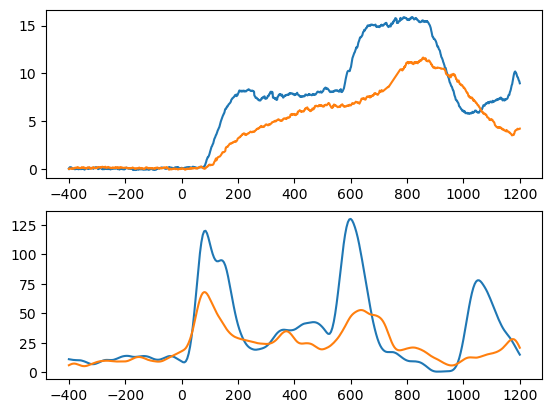

In [75]:
ndx = findall((mdall.=="Ar200103 1.0").&(spdall.==8).&(speedPulse.==8).&(prefD.==true)) #no null so do this first for example in F10
subplot(2,1,1)
xa_im = -400:1200
esp = eyeall[ndx[1]]
rmInstP!(esp)
IMfill!(esp)
plot(xa_im, esp)
esp = eyeall[ndx[3]]
rmInstP!(esp)
IMfill!(esp)
plot(xa_im, esp)
subplot(2,1,2)
plot(-400:5:1200, smooth(dataFRall[ndx[1]],20))
plot(-400:5:1200, smooth(dataFRall[ndx[3]],20))
save_figure_composer("F10AB.fyp")

In [76]:
xa_im=-400:900
for un in unique(mdall)
    if (sum(prefD[mdall.==un])/length(prefD[mdall.==un])) == 1 #if there is no null direction
        ndx = findall(mdall.==un)
        deleteat!(mdall, ndx)
        deleteat!(predFRall, ndx)
        deleteat!(dataFRall, ndx)
        deleteat!(cohall, ndx)
        deleteat!(spdall, ndx)
        deleteat!(psall, ndx)
        deleteat!(prefD, ndx)
        deleteat!(imall, ndx)
        deleteat!(eyeall, ndx)
        deleteat!(metric_fail, ndx)
        deleteat!(speedPulse, ndx)
        deleteat!(cohPulse, ndx)
        deleteat!(pulseTime, ndx)
    end
end

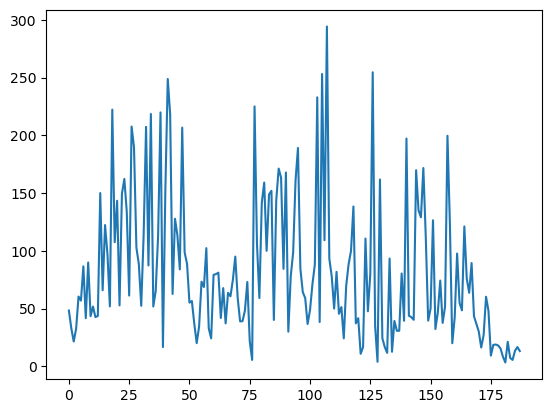

188-element Array{Real,1}:
 48.29059829059829
 32.945736434108525
 21.42857142857143
 32.592592592592595
 60.416666666666664
 56.91056910569105
 86.58536585365856
 41.666666666666664
 89.9122807017544
 43.40277777777778
 51.736111111111114
 42.592592592592595
 43.61111111111111
  ⋮
 18.518518518518515
 18.88888888888889
 18.055555555555554
 15.517241379310347
  8.333333333333334
  3.3333333333333335
 21.212121212121215
  7.291666666666667
  5.5555555555555545
 13.440860215053762
 16.666666666666668
 13.235294117647063

In [77]:
#normalize to peak response during intiation 
lg = 60
xa_im = -400:1200
binsz = 0.005
xa_pd = (-0.4:binsz:1.2)*1000
w = findall((lg).<=xa_pd.<(lg+lg))
winmax100 = Vector{Real}(undef, 0)
unm = unique(mdall)
xbounds = 2 .^ (0:0.125:6)
for un in unique(mdall)
    ndx = findall((cohall.==100).& (mdall.==un))
    hld=[]
    for ii in ndx
        push!(hld, mean(dataFRall[ii][w]))
    end
    push!(winmax100, maximum(hld))
end
plot(winmax100)
winmax100

<h3>F02</h3>

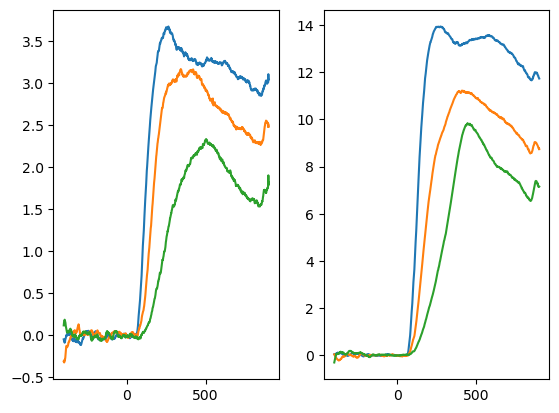

In [48]:
#speed tuning and examples, 2,3

#100,30,10 at 4 and 16
figure()
subplot(1,2,1)
ss=4
cape=1301
for hh in [100,30,10]
    ndx = findall((cohall.==hh).&(spdall.==ss).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
    esp = eyeall[ndx[1]]
    rmInstP!(esp)
    IMfill!(esp)
    ey=esp
    for ii = 2:length(ndx)
        esp = eyeall[ndx[ii]][1:cape]
        rmInstP!(esp)
        IMfill!(esp)
        ey = hcat(ey,esp)
    end
    plot(-400:900, mean(ey,dims=2))
end
subplot(1,2,2)
ss=16
for hh in [100,30,10]
    ndx = findall((cohall.==hh).&(spdall.==ss).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
    esp = eyeall[ndx[1]]
    rmInstP!(esp)
    IMfill!(esp)
    ey=esp
    for ii = 2:length(ndx)
        esp = eyeall[ndx[ii]][1:cape]
        rmInstP!(esp)
        IMfill!(esp)
        ey = hcat(ey,esp)
    end
    plot(-400:900, mean(ey,dims=2))
end

#save_figure_composer("F02AB.fyp")

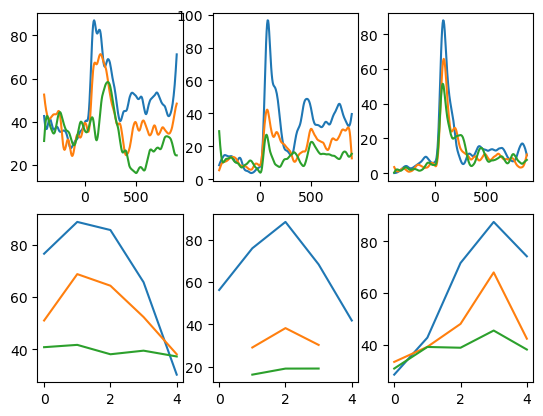

In [49]:
exs = "Ar190613 2.0", "Di220623 1.0", "Ar200724 1.0"
w = findall(60 .< (-400:5:900) .< 120)
ndx = findall((mdall.==exs[1]).&(spdall.==4).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0).&(cohall.!=70))
capn=261
subplot(2,3,1)
for ii in 1:length(ndx)
plot(-400:5:900, smooth(dataFRall[ndx[ii]][1:capn],20))
end
subplot(2,3,4)
for hh=[100,30,10]
    ndx = findall((mdall.==exs[1]).&(cohall.==hh).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
    hld=[]
    for ii=1:5
        push!(hld, mean(dataFRall[ndx[ii]][w]))
    end
    plot(hld)
end
subplot(2,3,2)
ndx = findall((mdall.==exs[2]).&(spdall.==8).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
psall[ndx]
for ii in 1:length(ndx)
plot(-400:5:900, smooth(dataFRall[ndx[ii]][1:capn],20))
end
subplot(2,3,5)
for hh=[100,30,10]
    ndx = findall((mdall.==exs[2]).&(cohall.==hh).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
    hld=[]
    for ii=1:length(ndx)
        push!(hld, mean(dataFRall[ndx[ii]][w]))
    end
    plot(log2.(sort(spdall[ndx])).-1, hld[sortperm(spdall[ndx])])
end
subplot(2,3,3)
ndx = findall((mdall.==exs[3]).&(spdall.==16).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0).&(cohall.!=70))
psall[ndx]
for ii in 1:length(ndx)
plot(-400:5:900, smooth(dataFRall[ndx[ii]][1:capn],20))
end
subplot(2,3,6)
for hh=[100,30,10]
    ndx = findall((mdall.==exs[3]).&(cohall.==hh).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
    hld=[]
    for ii=1:5
        push!(hld, mean(dataFRall[ndx[ii]][w]))
    end
    plot(hld)
end
#save_figure_composer("F02CH.fyp")

In [9]:
cd("C:\\Users\\scb47\\Documents\\MTdataprocess")
@load "PS_AMPS.jld2" COH modst PS PVR MONK MONKD
cd("C:\\Users\\scb47\\Documents\\MATLAB\\Figures")
for ii in 1:sum(MONK.=="A")
    MONKD[ii] = MONKD[ii]*".0"
end

In [10]:
#alt PS from the max of init response for hists, fits at low coh rough for comparisons though still important to see where they go
PSalt=Vector{Real}(undef, 0)
w = findall(60 .< (-400:5:900) .< 120)
spds = [2,4,8,16,32]
for ii in 1:length(MONKD)
    hld=[]
    for ss in spds
        ndx = findfirst((mdall.==MONKD[ii]).&(cohall.==COH[ii]).&(spdall.==ss).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
        if isnothing(ndx)
            push!(hld, 0)
        else
            push!(hld, mean(dataFRall[ndx][w]))
        end
    end
    push!(PSalt, spds[findmax(hld)[2]])
end

100
1.0
1.0
70
0.03262370226491384
0.9148169408608853
30
2.283071123560995e-6
0.15526327528544173
10
1.6067724816203863e-10
0.13064850801221461
100
1.0
1.0
30
2.1940087734496268e-13
0.4510897279918853
10
3.7061278304158083e-16
0.07033169310482097


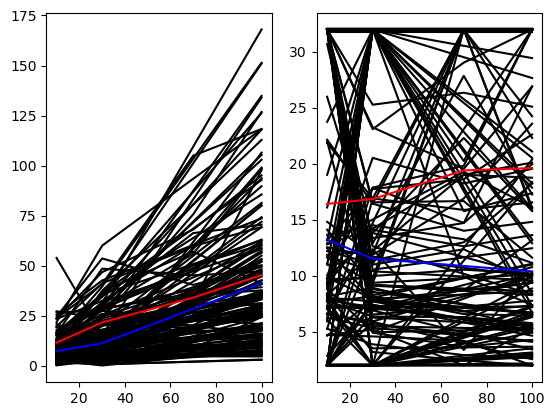

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000004A0D6908>

In [50]:
mcoh=[]
mavgPS=[]
mavgMS=[]
for mm in unique(MONK)
    h1=[]
    hld1=[]
    hld2=[]
    for hh in [100,70,30,10]
        ndx = findall((MONK.==mm).&(COH.==hh))
        if isempty(ndx)
            continue
        end
        push!(hld1, mean(modst[ndx]))
        push!(hld2, mean(PS[ndx]))
        push!(h1, hh)
        println(hh)
        println(pvalue(UnequalVarianceTTest(modst[findall((MONK.==mm).&(COH.==100))], modst[ndx])))
        println(pvalue(UnequalVarianceTTest(PS[findall((MONK.==mm).&(COH.==100))], PS[ndx])))
    end
    push!(mcoh, h1)
    push!(mavgPS, hld2)
    push!(mavgMS, hld1)
end
umd = unique(MONKD)
subplot(1,2,1)
for mm in 1:length(umd)
    ndx = findall(MONKD.==umd[mm])    
    plot(COH[ndx],modst[ndx],"k")
end
plot(mcoh[1],mavgMS[1],"r")
plot(mcoh[2],mavgMS[2],"b")
    
subplot(1,2,2)
for mm in 1:length(umd)
    ndx = findall(MONKD.==umd[mm])
    plot(COH[ndx],PS[ndx],"k")
end
plot(mcoh[1], mavgPS[1],"r")
plot(mcoh[2], mavgPS[2],"b")
#save_figure_composer("F02IJ.fyp")

<h3>F03</h3>

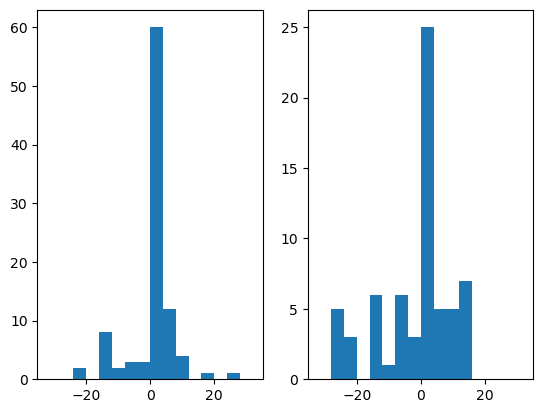

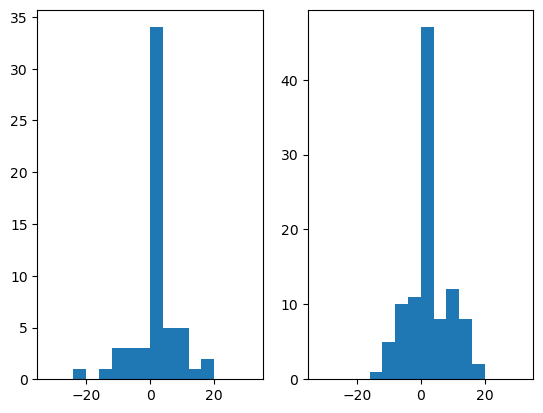

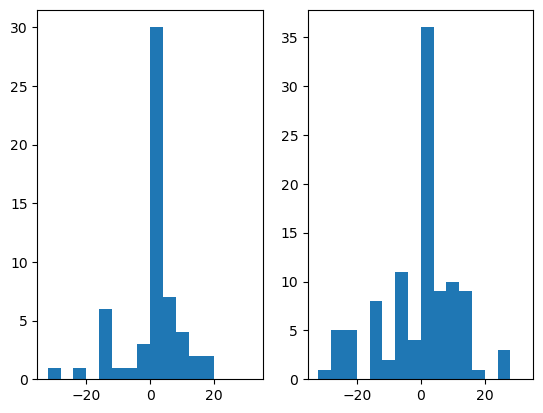

([1.0, 5.0, 5.0, 0.0, 8.0, 2.0, 11.0, 4.0, 36.0, 9.0, 10.0, 9.0, 1.0, 0.0, 3.0, 0.0], Int32[-32, -28, -24, -20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20, 24, 28, 32], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x0000000049FA8128>, PyObject <matplotlib.patches.Rectangle object at 0x0000000049FA9EB8>, PyObject <matplotlib.patches.Rectangle object at 0x0000000049FA86A0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000049FA89B0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000049FA8CC0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000049FA8FD0>, PyObject <matplotlib.patches.Rectangle object at 0x0000000032C0F320>, PyObject <matplotlib.patches.Rectangle object at 0x0000000032C0F630>, PyObject <matplotlib.patches.Rectangle object at 0x0000000032C0F940>, PyObject <matplotlib.patches.Rectangle object at 0x0000000032C0FC50>, PyObject <matplotlib.patches.Rectangle object at 0x0000000032C0FF60>, PyObject <matplotlib.patches.Rectangle object at 0

In [51]:
subplot(1,2,1)
ndx1=COH.==100
ndx2=COH.==30
hist((PSalt[ndx2].-PSalt[ndx1])[PVR[ndx2].<0.05], bins = -32:4:32)
subplot(1,2,2)
ndx1=COH.==100
ndx2=COH.==30
hist((PSalt[ndx2].-PSalt[ndx1])[PVR[ndx2].>0.05], bins = -32:4:32)
#save_figure_composer("F03AD.fyp")
figure()
subplot(1,2,1)
ndx1=COH.==30
ndx2=COH.==10
hist((PSalt[ndx2].-PSalt[ndx1])[PVR[ndx2].<0.05], bins = -32:4:32)
subplot(1,2,2)
ndx1=COH.==30
ndx2=COH.==10
hist((PSalt[ndx2].-PSalt[ndx1])[PVR[ndx2].>0.05], bins = -32:4:32)
#save_figure_composer("F03BE.fyp")
figure()
subplot(1,2,1)
ndx1=COH.==100
ndx2=COH.==10
hist((PSalt[ndx2].-PSalt[ndx1])[PVR[ndx2].<0.05], bins = -32:4:32)
subplot(1,2,2)
ndx1=COH.==100
ndx2=COH.==10
hist((PSalt[ndx2].-PSalt[ndx1])[PVR[ndx2].>0.05], bins = -32:4:32)
#save_figure_composer("F03CF.fyp")

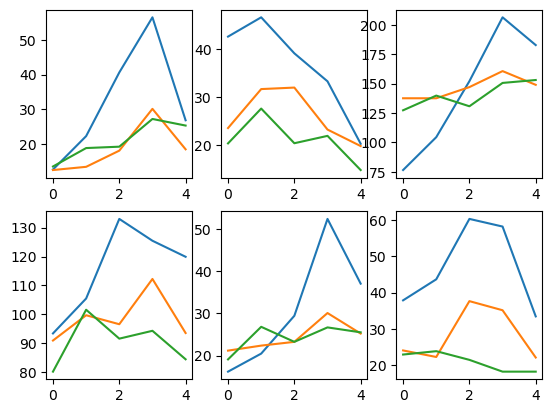

In [52]:
mdinc = "Ar190628 1.0", "Ar190703 1.0", "Ar200723 1.0"
mddec = "Ar200709 1.0", "Ar200630 1.0", "Ar200709 2.0"
for jj in 1:3
    subplot(2,3,jj)
    for hh=[100,30,10]
        ndx = findall((mdall.==mdinc[jj]).&(cohall.==hh).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
        hld=[]
        for ii=1:5
            push!(hld, mean(dataFRall[ndx[ii]][w]))
        end
        plot(log2.(sort(spdall[ndx])).-1, hld[sortperm(spdall[ndx])])
    end
end
for jj in 1:3
    subplot(2,3,jj+3)
    for hh=[100,30,10]
        ndx = findall((mdall.==mddec[jj]).&(cohall.==hh).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
        hld=[]
        for ii=1:5
            push!(hld, mean(dataFRall[ndx[ii]][w]))
        end
        plot(log2.(sort(spdall[ndx])).-1, hld[sortperm(spdall[ndx])])
    end
end
#save_figure_composer("F03GL.fyp")

In [14]:
PSalt
PVR
#find neurons with significant PVR and increase and and deacrease PSalt by more than 10
for mm in umd
    ndx = findall((MONKD.==mm).&(COH.!=70))
    if (sum(PVR[ndx].<0.05)==3) & (sum((diff(PSalt[ndx])).>=10)>0)
        #figure()
        #title(mm)
        println(mm)
        for hh=[100,30,10]
            ndx = findall((mdall.==mm).&(cohall.==hh).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
            hld=[]
            for ii =1:length(ndx)
                push!(hld, mean(dataFRall[ndx[ii]][w]))
            end
            #plot(log2.(sort(spdall[ndx])).-1, hld[sortperm(spdall[ndx])])
        end
    end
end 

Ar200723 1.0
Ar200804 1.0


<h3>F04</h3>

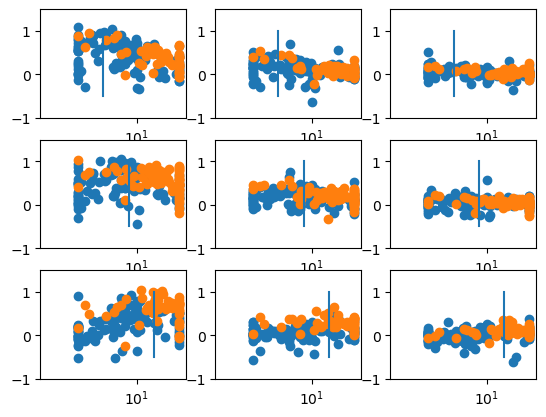

In [53]:
#population responses, 4
plt=0
for ss=[4,8,16]
    for hh=[100,30,10]
        #for monkey
        plt+=1
        subplot(3,3,plt)
        ndx = findall((cohall.==hh).&(spdall.==ss).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
        frA=[]
        nfrA=[]
        hldA=[]
        frD=[]
        nfrD=[]
        hldD=[]
        for ii in ndx            
            n = findfirst(mdall[ii].==unm)
            if mdall[ii][1]=='A'
                push!(frA, mean(dataFRall[ii][w])/winmax100[n])
                push!(hldA, psall[ii])
            elseif mdall[ii][1]=='D'                
                push!(frD, mean(dataFRall[ii][w])/winmax100[n])
                push!(hldD, psall[ii])
            end
        end
        ndx = findall((cohall.==hh).&(spdall.==ss).&(prefD.==false).&(speedPulse.==0).&(cohPulse.==0))
        for ii in ndx            
            n = findfirst(mdall[ii].==unm)
            if mdall[ii][1]=='A'
                push!(nfrA, mean(dataFRall[ii][w])/winmax100[n])
            elseif mdall[ii][1]=='D'
                push!(nfrD, mean(dataFRall[ii][w])/winmax100[n])
            end
        end
        scatter(hldD,frD.-nfrD)
        scatter(hldA,frA.-nfrA)
        xscale("symlog")
        ylim([-1,1.5])
        plot([ss,ss],[-0.5,1])
    end
end
#save_figure_composer("F04AI.fyp")

In [16]:
C=[]
A=[]
N=[]
w = findall((lg).<=xa_pd.<=(lg+lg))
ew = findall((195).<=xa_im.<=(205))
for hh=[100]
for ss in [2, 4, 8, 16, 32]
    ndx = findall((cohall.==hh) .& (spdall.==ss) .& (prefD.==false) .&(speedPulse.==0) .&(cohPulse.==0))
    fr=[]
    nfr=[]
    dve=[]
    for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
    end
    ndx = findall((cohall.==hh) .& (spdall.==ss) .& (prefD.==true) .&(speedPulse.==0) .&(cohPulse.==0))
    for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(fr, mean(dataFRall[ii][w])/winmax100[n])
            push!(dve, nanmean(eyeall[ii][ew]))
    end
    s = speeddecode(psall[ndx], fr, nfr, 0.15)
    c = (sum((fr.-nfr).*psall[ndx])  * log2(s)) /nanmean(dve)
    println(c)
    println(mean(fr.-nfr))#sum((fr.-nfr).*psall[ndx])/length(fr))
    push!(C, c)
    push!(A, mean(fr.-nfr))#sum((fr.-nfr).*psall[ndx])/length(fr))
    push!(N, length(fr))
    #c=180
    g = 1/c * sum((fr.-nfr).*psall[ndx])
    println(g)
    println([g*log2(s), nanmean(dve)])
    println()
    #scatter(ss, c/800, 10, "b")
    #scatter(ss, g/3.5, 10, "r")
end
end
#figure()
#scatter(A,C)
mean(C)

807.4421234650993
0.36774157812033004
0.7096737445217475
[1.8325598807604186, 1.8325598807604186]

544.9335613668803
0.40276270008956333
1.2215314127081633
[3.367266901549521, 3.3672669015495207]

616.6173057789408
0.477306943957735
2.0675647379482642
[6.859181817693933, 6.8591818176939325]

262.8799676383367
0.3532633114759161
3.535400545758033
[12.958005167297285, 12.958005167297285]

182.51345917704242
0.10568932803578217
2.5186397952127884
[12.093542753701282, 12.093542753701279]



482.8772834852599

<h3>F05</h3>

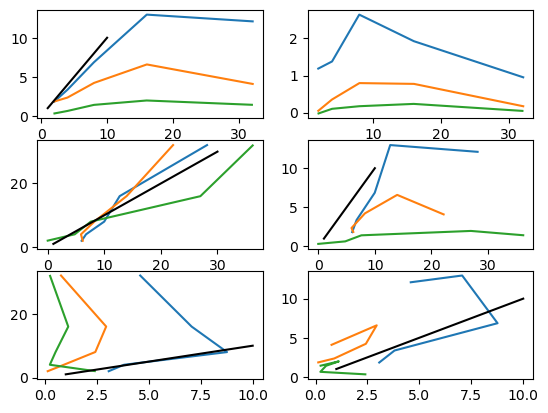

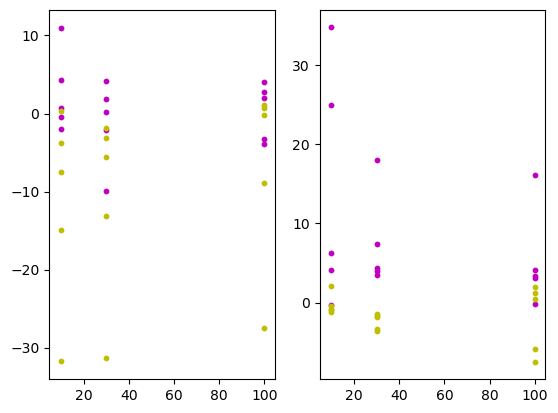

0.1568459455330613

In [25]:
c=mean(C)#350
epsi=0.1#or 1ss 
tt=0#or 600ss
iw = findall((tt).<=xa_im.<=(lg+tt))
w = findall((lg+tt).<=xa_pd.<=(lg+lg+tt))
ew = findall((195).<=xa_im.<=(205)) #for open loop, otherwise do difference between end of iw and 120 later

i6=[]
e6=[]
v6=[]
g6=[]
d6=[]

M_=[]
for hh in [100, 30, 10]
    VA = []
    IM = []
    E = []
    dcode = []
    G = []
    for ss in [2,4,8,16,32]
        fr=[]
        nfr=[]
        imm=[]
        dve=[]
        ndx = findall((prefD.==false).& (cohall.==hh).& (spdall.==ss).& (cohPulse.==0).& (speedPulse.==0))
        if isempty(ndx)
            continue
        end
        for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
        end
        ndx = findall((prefD.==true).& (cohall.==hh).& (spdall.==ss).& (cohPulse.==0).& (speedPulse.==0))
        for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(fr, mean(dataFRall[ii][w])/winmax100[n])
            push!(imm, nanmean(imall[ii][iw]))
            if tt==0
                push!(dve, nanmean(eyeall[ii][ew]))
            else
                push!(dve, eyeall[ii][iw[end]+120]-eyeall[ii][iw[end]])
            end
        end
        s = speeddecode(psall[ndx], fr, nfr, epsi)
        #c = (sum((fr.-nfr).*psall[ndx])  * log2(s)) /nanmean(dve)
        #push!(S_, s)
        push!(M_, mean(fr.-nfr))
        push!(VA, s)
        push!(IM, nanmean(imm))
        push!(E, nanmean(dve))
        g = 1/c * sum((fr.-nfr).*psall[ndx]) 
        push!(dcode, g*log2(s))
        push!(G, g)
    end  
    push!(i6, IM)
    push!(e6, E)
    push!(v6, VA)
    push!(g6, G)
    push!(d6, dcode)
end
figure()
subplot(3,2,1)
for ii in 1:3; plot(i6[ii], e6[ii]); end
plot([1,10],[1,10],"k")
subplot(3,2,2)
for ii in 1:3; plot(i6[ii], g6[ii]); end
subplot(3,2,3)
for ii in 1:3; plot(v6[ii], i6[ii]); end
plot([1,30],[1,30],"k")
subplot(3,2,4)
for ii in 1:3; plot(v6[ii], e6[ii]); end
plot([1,10],[1,10],"k")
subplot(3,2,5)
for ii in 1:3; plot(d6[ii], i6[ii]); end
plot([1,10],[1,10],"k")
subplot(3,2,6)
for ii in 1:3; plot(d6[ii], e6[ii]); end
plot([1,10],[1,10],"k")
#save_figure_composer("init600.fyp")

figure()
subplot(1,2,1)
cohs=[100,30,10]
for ii in [1,2,3]
    scatter(cohs[ii].*ones(size(i6[ii])), v6[ii].-i6[ii], 10, "m")
    scatter(cohs[ii].*ones(size(i6[ii])), d6[ii].-i6[ii], 10, "y")
end
subplot(1,2,2)
for ii in [1,2,3]
    scatter(cohs[ii].*ones(size(i6[ii])), v6[ii].-e6[ii], 10, "m")
    scatter(cohs[ii].*ones(size(i6[ii])), d6[ii].-e6[ii], 10, "y")
end
mean(M_)
#save_figure_composer("initCompare600.fyp")

<h3>F09</h3>

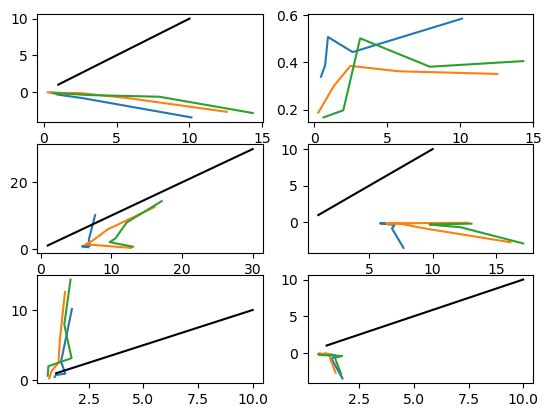

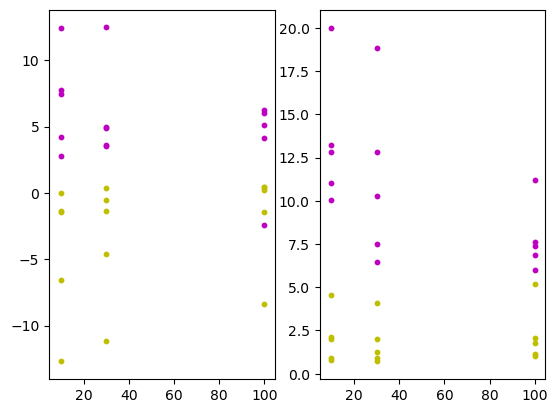

0.08989593740097766

In [26]:
c=mean(C)#350
epsi=1 
tt=600
iw = findall((tt).<=xa_im.<=(lg+tt))
w = findall((lg+tt).<=xa_pd.<=(lg+lg+tt))
ew = findall((195).<=xa_im.<=(205)) #for open loop, otherwise do difference between end of iw and 120 later

i6=[]
e6=[]
v6=[]
g6=[]
d6=[]

M_=[]
for hh in [100, 30, 10]
    VA = []
    IM = []
    E = []
    dcode = []
    G = []
    for ss in [2,4,8,16,32]
        fr=[]
        nfr=[]
        imm=[]
        dve=[]
        ndx = findall((prefD.==false).& (cohall.==hh).& (spdall.==ss).& (cohPulse.==0).& (speedPulse.==0))
        if isempty(ndx)
            continue
        end
        for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
        end
        ndx = findall((prefD.==true).& (cohall.==hh).& (spdall.==ss).& (cohPulse.==0).& (speedPulse.==0))
        for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(fr, mean(dataFRall[ii][w])/winmax100[n])
            push!(imm, nanmean(imall[ii][iw]))
            if tt==0
                push!(dve, nanmean(eyeall[ii][ew]))
            else
                push!(dve, eyeall[ii][iw[end]+120]-eyeall[ii][iw[end]])
            end
        end
        s = speeddecode(psall[ndx], fr, nfr, epsi)
        #c = (sum((fr.-nfr).*psall[ndx])  * log2(s)) /nanmean(dve)
        #push!(S_, s)
        push!(M_, mean(fr.-nfr))
        push!(VA, s)
        push!(IM, nanmean(imm))
        push!(E, nanmean(dve))
        g = 1/c * sum((fr.-nfr).*psall[ndx]) 
        push!(dcode, g*log2(s))
        push!(G, g)
    end  
    push!(i6, IM)
    push!(e6, E)
    push!(v6, VA)
    push!(g6, G)
    push!(d6, dcode)
end
figure()
subplot(3,2,1)
for ii in 1:3; plot(i6[ii], e6[ii]); end
plot([1,10],[1,10],"k")
subplot(3,2,2)
for ii in 1:3; plot(i6[ii], g6[ii]); end
subplot(3,2,3)
for ii in 1:3; plot(v6[ii], i6[ii]); end
plot([1,30],[1,30],"k")
subplot(3,2,4)
for ii in 1:3; plot(v6[ii], e6[ii]); end
plot([1,10],[1,10],"k")
subplot(3,2,5)
for ii in 1:3; plot(d6[ii], i6[ii]); end
plot([1,10],[1,10],"k")
subplot(3,2,6)
for ii in 1:3; plot(d6[ii], e6[ii]); end
plot([1,10],[1,10],"k")
#save_figure_composer("init600.fyp")

figure()
subplot(1,2,1)
cohs=[100,30,10]
for ii in [1,2,3]
    scatter(cohs[ii].*ones(size(i6[ii])), v6[ii].-i6[ii], 10, "m")
    scatter(cohs[ii].*ones(size(i6[ii])), d6[ii].-i6[ii], 10, "y")
end
subplot(1,2,2)
for ii in [1,2,3]
    scatter(cohs[ii].*ones(size(i6[ii])), v6[ii].-e6[ii], 10, "m")
    scatter(cohs[ii].*ones(size(i6[ii])), d6[ii].-e6[ii], 10, "y")
end
mean(M_)
#save_figure_composer("initCompare600.fyp")

<h3>F10</h3>

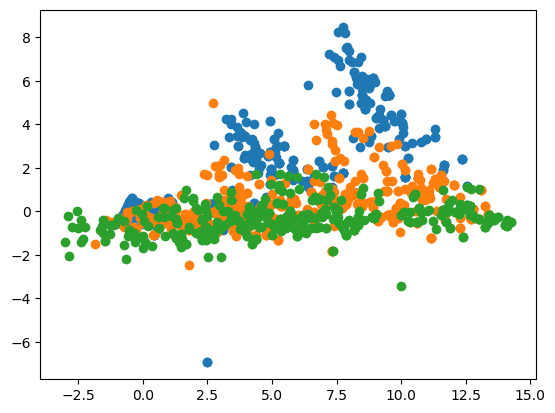

In [72]:
#image vs delta eye

iw = findall((500).<xa_im.<=(560))
for hh in [100,30,10]
    imm=[]
    dv=[]
    for ss in [0,4,8,11,12]
        ndx = findall((prefD.==true).& (cohall.==hh).& (spdall.==8).& (cohPulse.==0).& (speedPulse.==ss))
        for ii in ndx
            push!(imm, nanmean(imall[ii][iw]))
            push!(dv, (eyeall[ii][iw[end]+120]-eyeall[ii][iw[end]]))
        end
    end
    scatter(imm, dv)
end
#save_figure_composer("F10C.fyp")

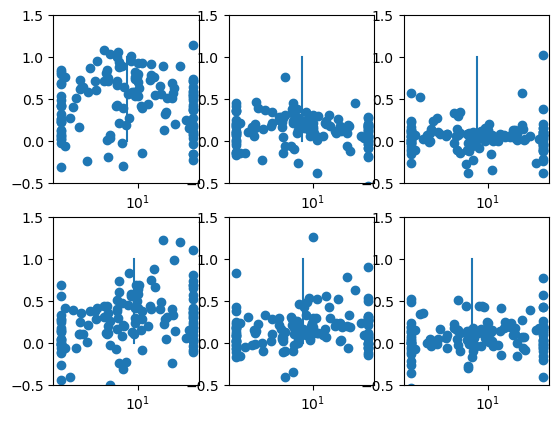

In [85]:
#pop responses init v 8
plt=0
ss=8
ssp=8
for tt=[0,500]
iw = findall((tt).<=xa_im.<=(lg+tt))
w = findall((lg+tt).<=xa_pd.<=(lg+lg+tt))
for hh in [100,30,10]
    plt+=1
    subplot(2,3,plt)
    fr=[]
    nfr=[]
    ps=[]
    imm=[]
    ndx = findall((cohall.==hh).&(spdall.==ss).&(prefD.==true).&(speedPulse.==ssp).&(cohPulse.==0))
    for ii in ndx
        n = findfirst(mdall[ii].==unm)
        push!(imm, nanmean(imall[ii][iw]))
        push!(fr, mean(dataFRall[ii][w])/winmax100[n])
        push!(ps, psall[ii])
    end
    ndx = findall((cohall.==hh).&(spdall.==ss).&(prefD.==false).&(speedPulse.==ssp).&(cohPulse.==0))
    for ii in ndx
        n = findfirst(mdall[ii].==unm)
        push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
    end
    scatter(ps, fr.-nfr)
    plot([mean(imm),mean(imm)], [0,1])
    xscale("symlog")
    ylim([-0.5,1.5])
end
end 

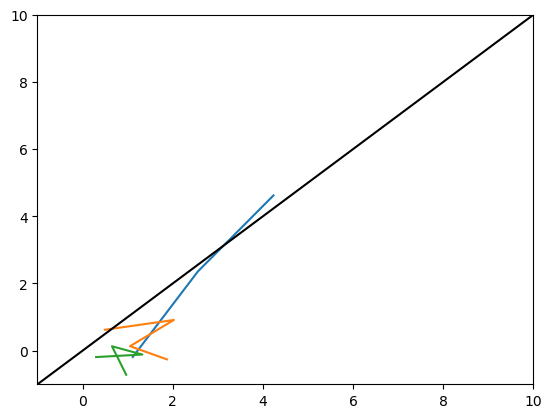

(-1, 10)

In [91]:
#decode eye vs gva
c=mean(C)#330
epsi=1#0.15
i6=[]
e6=[]
v6=[]
g6=[]
d6=[]
for hh in [100, 30, 10]
    VA = []
    IM = []
    E = []
    dcode = []
    G = []
    for ss in [0,4,8,11,12]
        fr=[]
        nfr=[]
        imm=[]
        dve=[]
        ndx = findall((prefD.==false).& (cohall.==hh).& (spdall.==8).& (cohPulse.==0).& (speedPulse.==ss))
        if isempty(ndx)
            continue
        end
        for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
        end
        ndx = findall((prefD.==true).& (cohall.==hh).& (spdall.==8).& (cohPulse.==0).& (speedPulse.==ss))
        for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(fr, mean(dataFRall[ii][w])/winmax100[n])
            push!(imm, nanmean(imall[ii][iw]))
            push!(dve, eyeall[ii][iw[end]+120]-eyeall[ii][iw[end]])
        end
        push!(VA, speeddecode(psall[ndx], fr, nfr, epsi))
        push!(IM, nanmean(imm))
        push!(E, nanmean(dve))
        g = 1/c * sum((fr.-nfr).*psall[ndx]) 
        push!(dcode, g*log2(speeddecode(psall[ndx], fr, nfr, epsi)))
        push!(G, g)
    end  
    push!(i6, IM)
    push!(e6, E)
    push!(v6, VA)
    push!(g6, G)
    push!(d6, dcode)
end
for ii in 1:3; plot(d6[ii], e6[ii]); end
plot([-1,10],[-1,10],"k")
ylim([-1,10])
xlim([-1,10])
#save_figure_composer("F10J.fyp")

<h3>F11</h3>

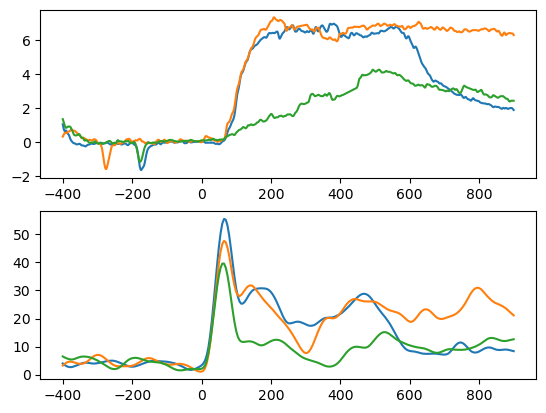

In [92]:
#coherence pulses
#traces
ndx1 = findfirst((mdall.=="Di220619 1.0").&(spdall.==8).&(cohPulse.==-90).&(speedPulse.==0).&(prefD.==true))
ndx2 = findfirst((mdall.=="Di220619 1.0").&(spdall.==8).&(cohall.==100).&(cohPulse.==0).&(speedPulse.==0).&(prefD.==true))
ndx3 = findfirst((mdall.=="Di220619 1.0").&(spdall.==8).&(cohall.==10).&(cohPulse.==0).&(speedPulse.==0).&(prefD.==true))
subplot(2,1,1)
esp = eyeall[ndx1]./1
rmInstP!(esp)
IMfill!(esp)
plot(-400:900, smooth(esp[1:cape]))
esp = eyeall[ndx2]./1
rmInstP!(esp)
IMfill!(esp)
plot(-400:900, smooth(esp[1:cape]))
esp = eyeall[ndx3]./1
rmInstP!(esp)
IMfill!(esp)
plot(-400:900, smooth(esp[1:cape]))
subplot(2,1,2)
plot(-400:5:900, smooth(dataFRall[ndx1],20)[1:capn])
plot(-400:5:900, smooth(dataFRall[ndx2],20)[1:capn])
plot(-400:5:900, smooth(dataFRall[ndx3],20)[1:capn])
save_figure_composer("F11AB.fyp")

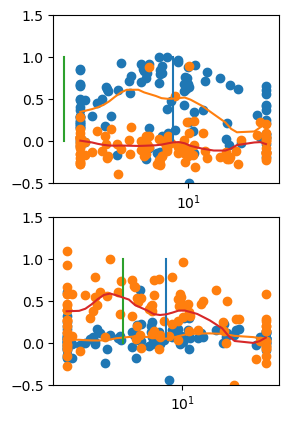

In [98]:
#pop responses
xbounds = 2 .^ (0:0.125:6)
subplot(2,2,1)
for tt = [0,500]
    iw = findall((tt).<=xa_im.<=(lg+tt))
    w = findall((lg+tt).<=xa_pd.<=(lg+lg+tt))    
    ndx = findall((spdall.==8).&(prefD.==true).&(cohPulse.==-90))
    fr=[]
    nfr=[]
    ps=[]
    imm=[]
    for ii in ndx
        n = findfirst(mdall[ii].==unm)
        push!(imm, nanmean(imall[ii][iw]))
        push!(fr, mean(dataFRall[ii][w])/winmax100[n])
        push!(ps, psall[ii])
    end
    ndx = findall((spdall.==8).&(prefD.==false).&(cohPulse.==-90))
    for ii in ndx
        n = findfirst(mdall[ii].==unm)
        push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
    end
    scatter(ps, fr.-nfr)
    plot([mean(imm),mean(imm)], [0,1])
    xscale("symlog")
    ylim([-0.5,1.5])
    #popaverage
    ld1=Vector{Float64}(undef, 0)
    x1=Vector{Float64}(undef, 0)
    for ii in 2:length(xbounds)
        ndx = findall(xbounds[ii-1] .<= ps .< xbounds[ii])
        if isempty(ndx)
            continue
        end
        push!(ld1, mean((fr.-nfr)[ndx]))    
        push!(x1, xbounds[ii-1])
    end
    plot(x1, smooth(ld1))
end

subplot(2,2,3)
for tt = [0,500]
    iw = findall((tt).<=xa_im.<=(lg+tt))
    w = findall((lg+tt).<=xa_pd.<=(lg+lg+tt))    
    ndx = findall((spdall.==8).&(prefD.==true).&(cohPulse.==90))
    fr=[]
    nfr=[]
    ps=[]
    imm=[]
    for ii in ndx
        n = findfirst(mdall[ii].==unm)
        push!(imm, nanmean(imall[ii][iw]))
        push!(fr, mean(dataFRall[ii][w])/winmax100[n])
        push!(ps, psall[ii])
    end
    ndx = findall((spdall.==8).&(prefD.==false).&(cohPulse.==90))
    for ii in ndx
        n = findfirst(mdall[ii].==unm)
        push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
    end
    scatter(ps, fr.-nfr)
    plot([mean(imm),mean(imm)], [0,1])
    xscale("symlog")
    ylim([-0.5,1.5])
    #popaverage
    ld1=Vector{Float64}(undef, 0)
    x1=Vector{Float64}(undef, 0)
    for ii in 2:length(xbounds)
        ndx = findall(xbounds[ii-1] .<= ps .< xbounds[ii])
        if isempty(ndx)
            continue
        end
        push!(ld1, mean((fr.-nfr)[ndx]))    
        push!(x1, xbounds[ii-1])
    end
    plot(x1, smooth(ld1))
end

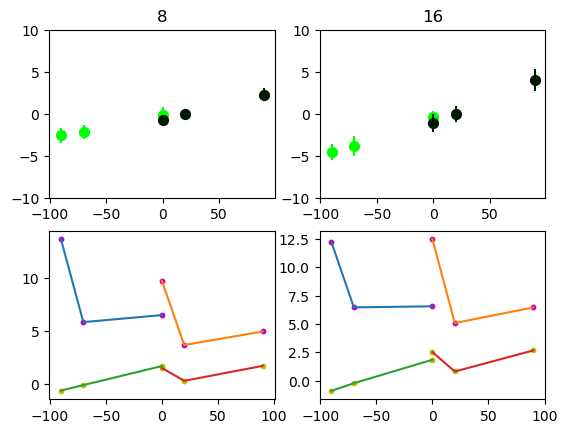

In [115]:
#decoders
epsi=0.15
c=330 #smaller pop

p=0
i_v=[]
i_d=[]
e_v=[]
e_d=[]
x_a=[]
for ss in [8,16]
    p+=1
    subplot(2,2,p)
    title(ss)
    m_x=[]
    m_y=[]
    y_x=[]
    y_y=[]
    hlf=Vector{Bool}(undef, 0)
    for hh in unique(cohPulse)
        for h in [100,10]#unique(cohall)
            imm=[]
            acc=[]
            fr=[]
            ps=[]
            nfr=[]
            hldf=[]
            hlda=[]
            hldi=[]
            dcode=[]
            gcode=[]
            ndx = findall((prefD.==true).& (speedPulse.==0).& (spdall.==ss).& (cohPulse.==hh).& (cohall.==h))
            if isempty(ndx)
                continue
            end
            for ii in ndx
                n = findfirst(mdall[ii].==unm)
                push!(imm, nanmean(imall[ii][iw]))
                    push!(acc, eyeall[ii][iw[end]+120]-eyeall[ii][iw[end]])
                push!(fr, mean(dataFRall[ii][w])/winmax100[n])
                push!(ps, psall[ii])
            end
            #
            push!(hldi, nanmean(imm))
            push!(hldf, nanmean(fr))
            push!(hlda, nanmean(acc))
            ndx = findall((prefD.==false).& (speedPulse.==0).& (spdall.==ss).& (cohPulse.==hh).& (cohall.==h))
            for ii in ndx
                n = findfirst(mdall[ii].==unm)
                push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
            end
            push!(dcode, speeddecode(ps, fr, nfr, epsi))
            g = 1/c * sum((fr.-nfr).*ps)
            push!(gcode, g*log2(dcode[end]))
            scatter(hh.*ones(size(hlda)), hlda, 50, [0 h/100 0])
            plot([hh.*ones(size(hlda)), hh.*ones(size(hlda))], [hlda, hlda.+nanstd(acc)], color=(0,h/100,0))
            plot([hh.*ones(size(hlda)), hh.*ones(size(hlda))], [hlda, hlda.-nanstd(acc)], color=(0,h/100,0))
            ax = gca()
            ax[:set_ylim]([-10,10])

            push!(m_x, hh.*ones(size(dcode)))
            push!(m_y, dcode)
            push!(y_x, hh.*ones(size(gcode)))
            push!(y_y, gcode)
            push!(i_v, hldi-dcode)
            push!(i_d, hldi-gcode)
            push!(e_v, hlda-dcode)
            push!(e_d, hlda-gcode)
            push!(x_a, hh)
            
            if h==100
                push!(hlf, true)
            else
                push!(hlf, false)
            end
        end
    end 
    subplot(2,2,p+2)
    scatter(m_x,m_y,10,"m")
    scatter(y_x,y_y, 10,"y")
    
    plot(sort(m_x[hlf]), m_y[hlf][sortperm(m_x[hlf])])
    plot(sort(m_x[.~hlf]), m_y[.~hlf][sortperm(m_x[.~hlf])])
    plot(sort(y_x[hlf]), y_y[hlf][sortperm(y_x[hlf])])
    plot(sort(y_x[.~hlf]), y_y[.~hlf][sortperm(y_x[.~hlf])])
end
#save_figure_composer("F11EF.fyp")

In [28]:
#N=[]
#F=[]

In [27]:
#what epsi do I need at different firing rates to prevent excessive overestimation?
#=
tt=600#0
iw = findall((tt).<=xa_im.<=(lg+tt))
w = findall((lg+tt).<=xa_pd.<=(lg+lg+tt))
ew = findall((195).<=xa_im.<=(205)) 
i6=[]
e6=[]
v6=[]
for hh in [100, 30, 10]
    VA = []
    IM = []
    E = []
    dcode = []
    G = []
    for ss in [2,4,8,16,32]
        fr=[]
        nfr=[]
        imm=[]
        dve=[]
        ndx = findall((prefD.==false).& (cohall.==hh).& (spdall.==ss).& (cohPulse.==0).& (speedPulse.==0))
        for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
        end
        ndx = findall((prefD.==true).& (cohall.==hh).& (spdall.==ss).& (cohPulse.==0).& (speedPulse.==0))
        for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(fr, mean(dataFRall[ii][w])/winmax100[n])
            push!(imm, nanmean(imall[ii][iw]))
            if tt==0
                push!(dve, nanmean(eyeall[ii][ew]))
            else
                push!(dve, eyeall[ii][iw[end]+120]-eyeall[ii][iw[end]])
            end
        end
        epsi = 0.15
        
        hld=[]
        for ee in 0:0.05:2
            push!(hld, abs(speeddecode(psall[ndx], fr, nfr, ee) - nanmean(imm)))
        end
        epsi = (0:0.05:2)[findmin(hld)[2]]
        push!(N, epsi)
        push!(F, mean(fr.-nfr)) 
        s = speeddecode(psall[ndx], fr, nfr, epsi)
        push!(VA, s)
        push!(IM, nanmean(imm))
        push!(E, nanmean(dve))
    end  
    push!(i6, IM)
    push!(e6, E)
    push!(v6, VA)
end
figure()
subplot(3,2,1)
for ii in 1:3; plot(i6[ii], e6[ii]); end
plot([1,10],[1,10],"k")

subplot(3,2,3)
for ii in 1:3; plot(v6[ii], i6[ii]); end
plot([1,30],[1,30],"k")
subplot(3,2,4)
for ii in 1:3; plot(v6[ii], e6[ii]); end
plot([1,10],[1,10],"k")

figure()
scatter(F,N)
=#